### Score: 52.5

Q1.[4+5+5]

Q2.[11+11]

Q3.[5.5+11]

**Collaboration:**  

Collaboration on solving the assignment is allowed, after you have thought about the problem sets on your own. It is also OK to get clarification (but not solutions) from online resources, again after you have thought about the problem sets on your own. 

There are two requirements for collaboration: 

* Cite your collaborators **fully and completely** (*e.g.*, "XXX explained to me what is asked in problem set 3"). Or cite online resources (*e.g.*, "I got inspired by reading XXX") that helped you.

* Write your scripts and report **independently** - the scripts and report must come from you only.

# 1. Global methane levels from 2002

**1.1** [5 points] Compute methane climatology for each month, and plot your results in 12 panels.

In [35]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 读取 NetCDF 数据文件
methane_data = xr.open_dataset(r'C:\Users\zjm\Desktop\ESE_5023\200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc')


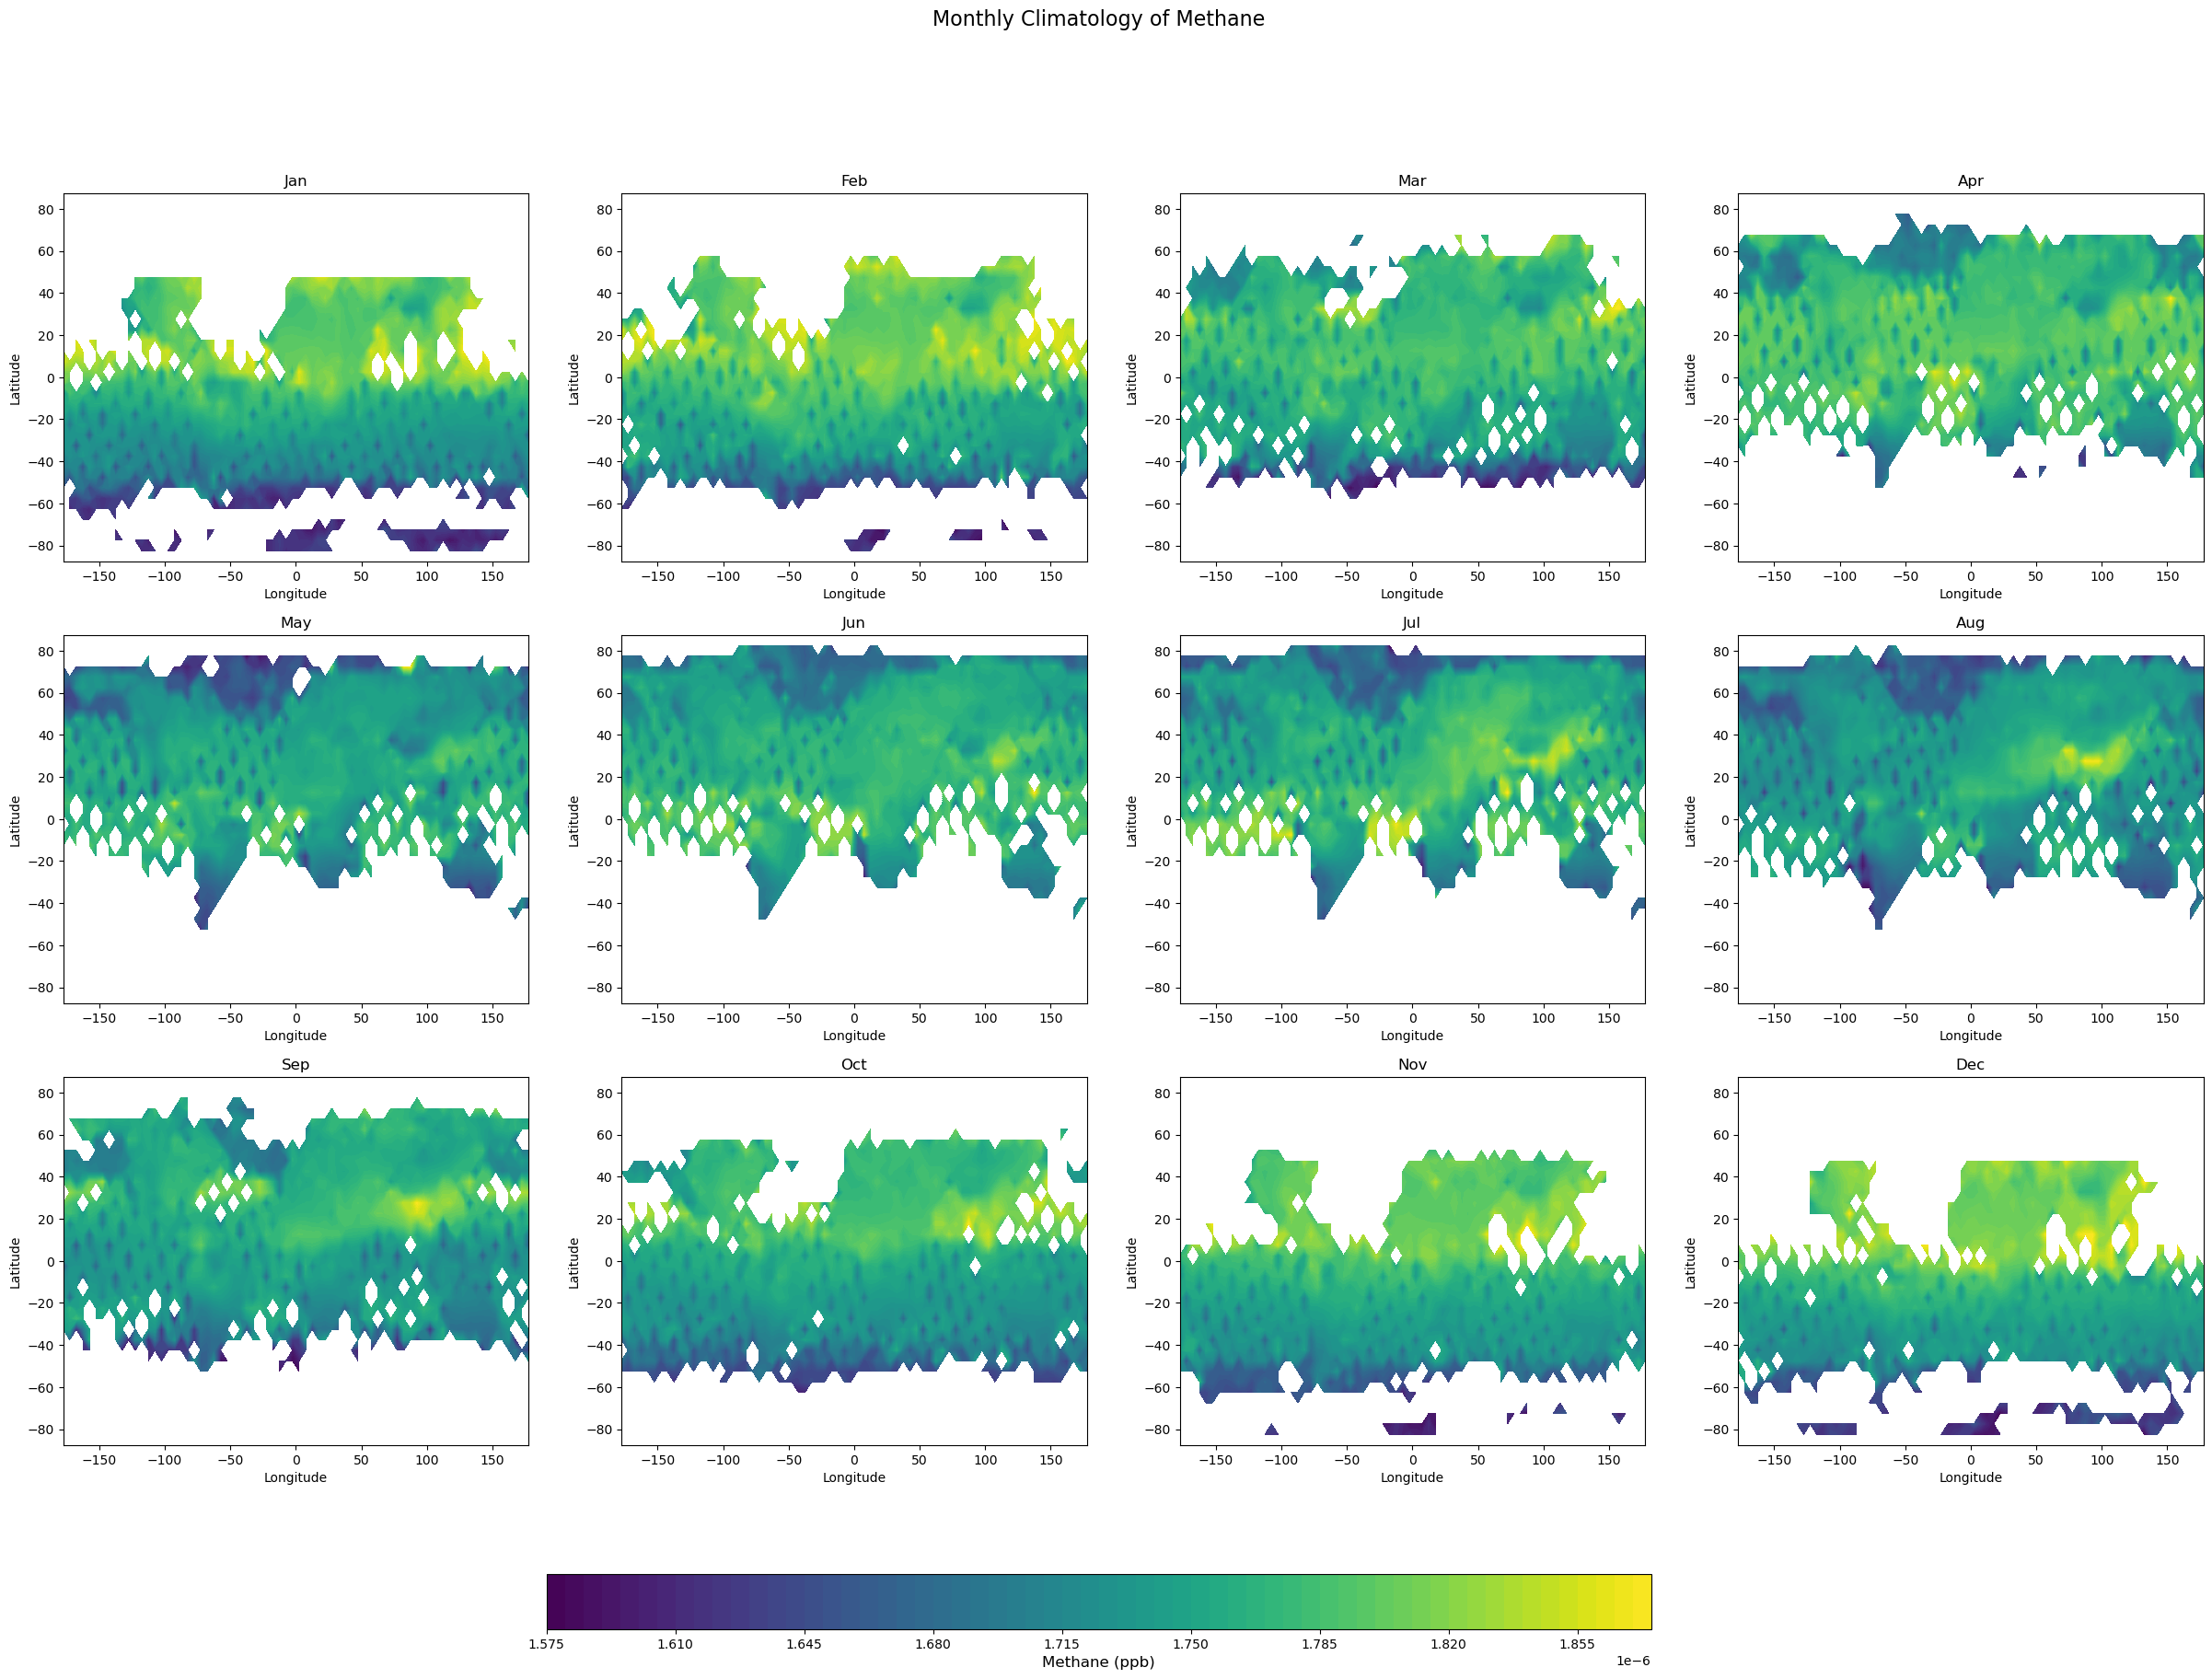

In [36]:
# 变量名 'xch4' 表示甲烷浓度
xch4 = methane_data['xch4']  

# 确保时间信息解析正确
xch4['time'] = xr.cftime_range(start="2003-01", periods=len(xch4['time']), freq="MS")

# 按月份分组，计算每个月的气候学平均值
monthly_climatology = xch4.groupby('time.month').mean(dim='time')

# 定义绘图网格
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(30, 20), subplot_kw={'projection': None})

# 月份标签
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# 获取经纬度信息
lons = methane_data['lon']
lats = methane_data['lat']
lon_grid, lat_grid = np.meshgrid(lons, lats)

# 逐月绘制
for i, ax in enumerate(axes.flat):
    month_data = monthly_climatology.sel(month=i + 1)  # 提取该月数据
    im = ax.contourf(lon_grid, lat_grid, month_data, levels=60, cmap='viridis')
    ax.set_title(months[i])  # 设置子图标题
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

# 调整颜色条
fig.subplots_adjust(bottom=0.2)  # 调整子图和底部边距，为颜色条腾出空间
cbar_ax = fig.add_axes([0.3, 0.1, 0.4, 0.03])  # 定义颜色条的位置，[左, 下, 宽度, 高度]
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
# NOTE: 数据已经乘以了1e-6，此处量纲应为1 -1
cbar.set_label('Methane (ppb)', fontsize=12)

# 添加全局标题
plt.suptitle('Monthly Climatology of Methane', fontsize=16)
plt.show()


**1.2** [5 points] Plot globally-averaged methane from 2003-01 to 2020-06 as a time series. Describe your results. Check your plot with this one.

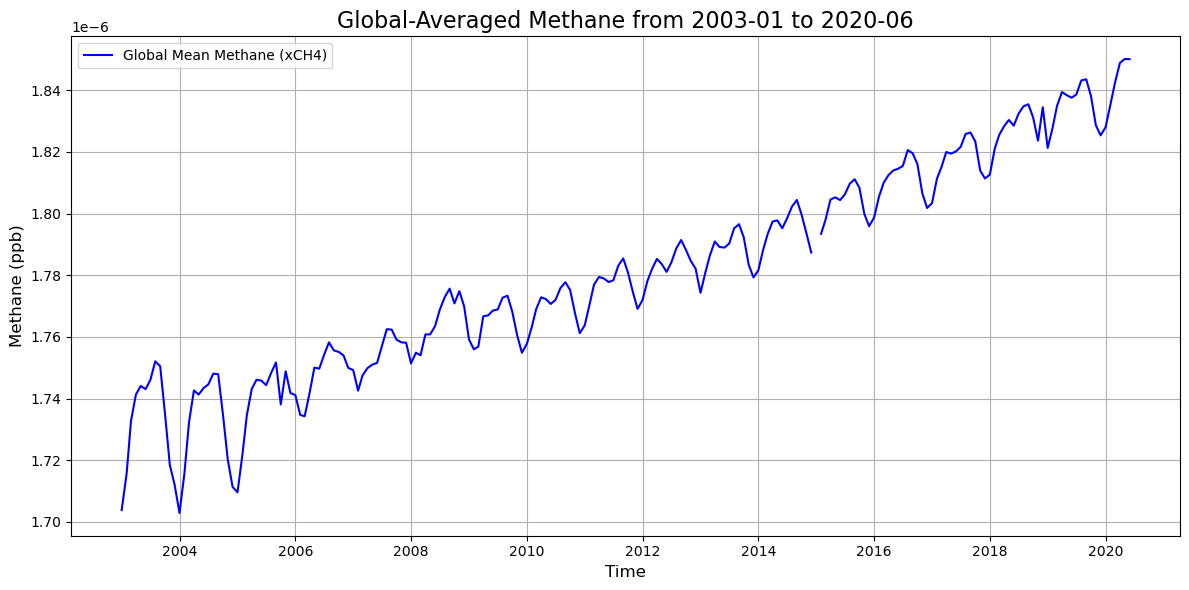

In [37]:
# 计算全球平均甲烷浓度时间序列
global_mean_time_series = xch4.mean(dim=['lat', 'lon'])

# 将 CFTimeIndex 转换为标准 datetime
time_in_datetime = [np.datetime64(t) for t in global_mean_time_series['time'].values]

# 绘制时间序列
plt.figure(figsize=(12, 6))
plt.plot(time_in_datetime, global_mean_time_series, label='Global Mean Methane (xCH4)', color='blue')

# 添加标题和轴标签
plt.title('Global-Averaged Methane from 2003-01 to 2020-06', fontsize=16)
plt.xlabel('Time', fontsize=12)
# NOTE: 问题同1.1
plt.ylabel('Methane (ppb)', fontsize=12)
plt.grid()
plt.legend()
plt.tight_layout()

# 显示图像
plt.show()


### **描述图像**
通过这个图像可以看出：全球甲烷浓度的长期上升趋势，同时呈现出明显的，周期性的短期波动。

**1.3** [5 points] Plot deseasonalized methane levels at point [15°S, 150°W] from 2003-01 to 2020-06 as a time series. Describe your results.

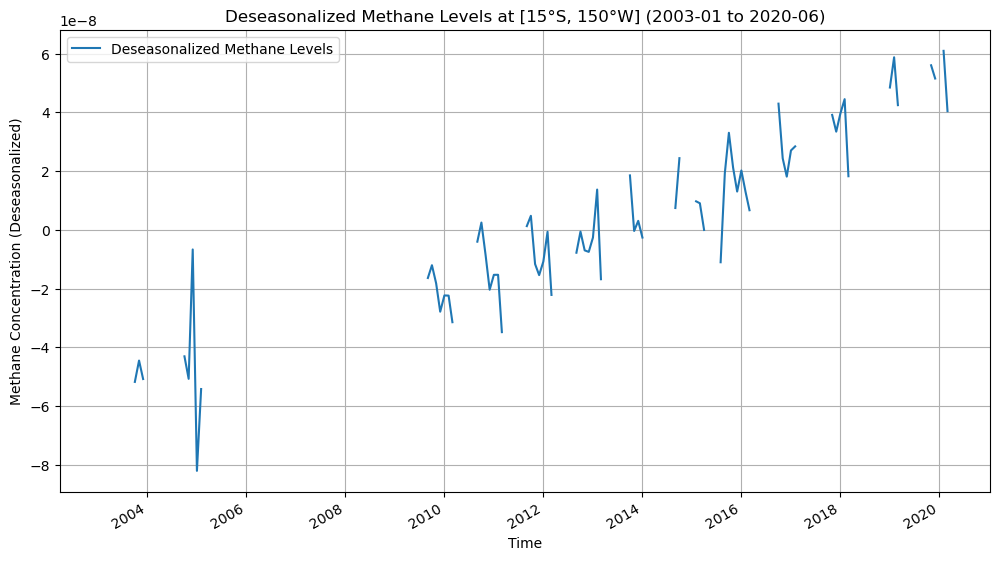

In [38]:
# 选择指定的地理位置 [15°S, 150°W] 的甲烷数据
lat_point = -15  # 15°S
lon_point = -150  # 150°W

# 在数据集中找到最接近的纬度和经度点
selected_point = xch4.sel(lat=lat_point, lon=lon_point, method='nearest')

# 计算每月的平均值，以获得季节性周期
seasonal_cycle = selected_point.groupby('time.month').mean(dim='time')

# 去季节化，将每月的数据减去相应的季节性周期
deseasonalized_methane = selected_point.groupby('time.month') - seasonal_cycle
deseasonalized_methane["time"] = deseasonalized_methane["time"].astype("datetime64[ns]")

# 绘制去季节化后的甲烷浓度时间序列图
plt.figure(figsize=(12, 6))
deseasonalized_methane.plot(label='Deseasonalized Methane Levels')
plt.title("Deseasonalized Methane Levels at [15°S, 150°W] (2003-01 to 2020-06)")
plt.xlabel("Time")
plt.ylabel("Methane Concentration (Deseasonalized)")
plt.legend()
plt.grid()
plt.show()


### **描述图像**
1. 2005年前后的甲烷浓度波动较大，数值大多为负，约在-8到0之间。

2. 2005-2015年，甲烷浓度在此期间逐渐上升，尽管有显著的波动。数值逐渐增至正数，显示出总体上升趋势。

3. 在2015年后，甲烷浓度的上升趋势更加显著，波动减少，数值逐渐接近或超过0，甚至达到6左右。

总的来看，去季节化的甲烷浓度水平在这段时间内整体呈现上升趋势，尤其是在2015年以后增加显著。


# 2. Niño 3.4 index

**2.1** [10 points] Compute monthly climatology for SST from Niño 3.4 region, and subtract climatology from SST time series to obtain anomalies.

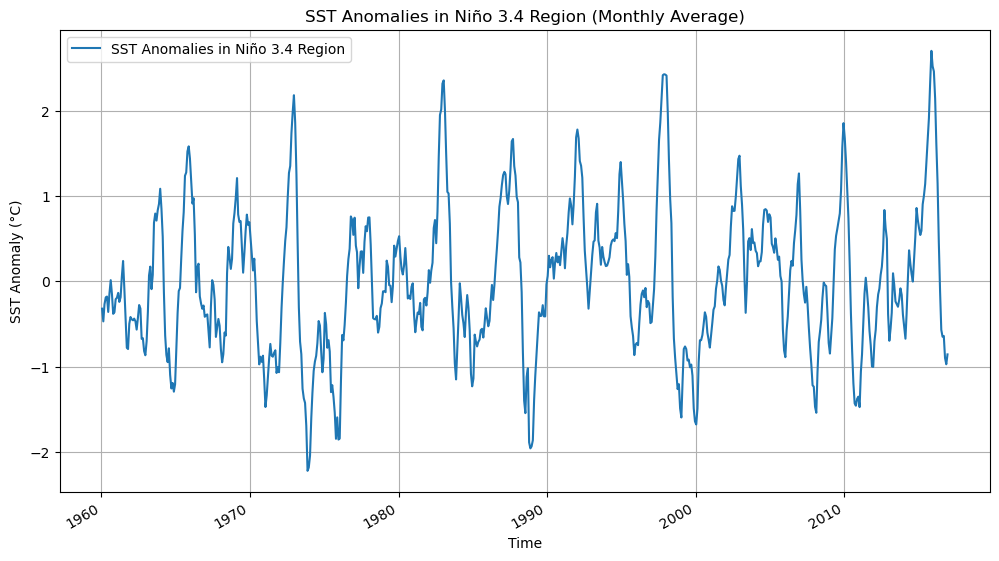

In [39]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# 读取NetCDF数据文件
sst_data = xr.open_dataset(r'C:\Users\zjm\Desktop\ESE_5023\NOAA_NCDC_ERSST_v3b_SST.nc')

# 定义Niño 3.4区域的经纬度范围
# 纬度范围：5°S到5°N，经度范围：170°W到120°W
nino_3_4_lat_range = slice(-5, 5)    # 纬度范围
nino_3_4_lon_range = slice(190, 240) # 经度范围

# 提取Niño 3.4区域的SST数据
sst_nino_3_4 = sst_data['sst'].sel(lat=nino_3_4_lat_range, lon=nino_3_4_lon_range)

# 计算每个月的气候平均值（长期月平均值）
# 通过groupby将数据按月分组，然后计算多年的月平均值
monthly_climatology = sst_nino_3_4.groupby('time.month').mean(dim='time')

# 计算SST异常值（Anomalies），从原始SST数据中减去对应月份的气候平均值
sst_anomalies = sst_nino_3_4.groupby('time.month') - monthly_climatology

# 对计算出的异常值在纬度和经度上取平均，得到区域平均的异常值
sst_anomalies_mean = sst_anomalies.mean(dim=['lat', 'lon'])

# 可视化结果
plt.figure(figsize=(12, 6))
sst_anomalies_mean.plot(label='SST Anomalies in Niño 3.4 Region')
plt.title("SST Anomalies in Niño 3.4 Region (Monthly Average)")
plt.xlabel("Time")
plt.ylabel("SST Anomaly (°C)")
plt.legend()
plt.grid()
plt.show()


**2.2** [10 points] Visualize the computed Niño 3.4. Your plot should look similar to this one.

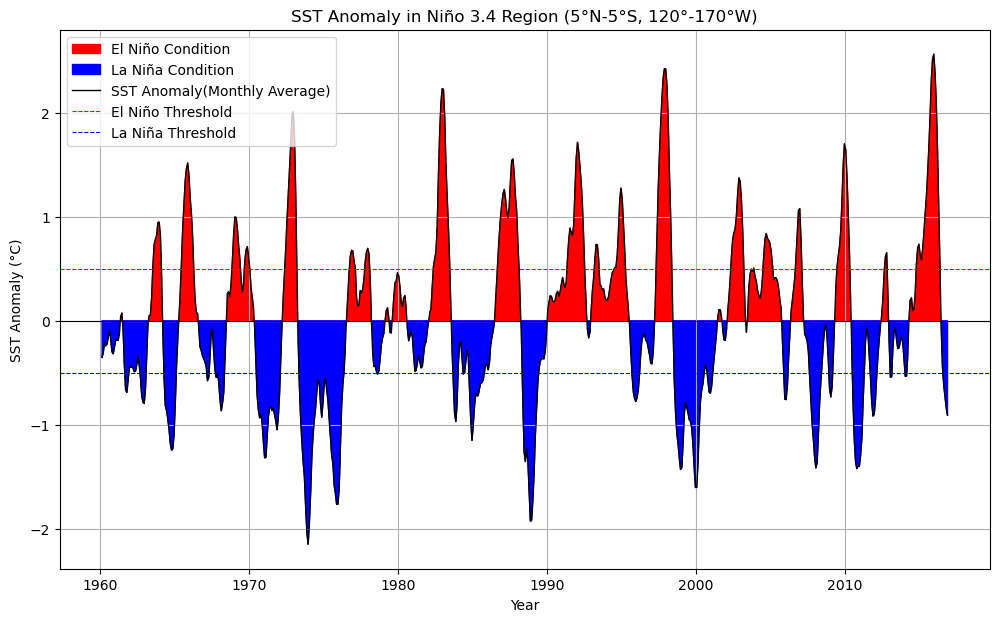

In [40]:
# 定义 El Niño 和 La Niña 的阈值
el_nino_threshold = 0.5
la_nina_threshold = -0.5

# 计算 3 个月移动平均
sst_anomalies_rolling = sst_anomalies_mean.rolling(time=3, center=True).mean()

# 绘制图形
plt.figure(figsize=(12, 7))

# 填充 El Niño 区域
plt.fill_between(sst_anomalies_mean['time'], sst_anomalies_rolling, 0, 
                 where=(sst_anomalies_rolling >= 0), 
                 color='red', label="El Niño Condition")

# 填充 La Niña 区域
plt.fill_between(sst_anomalies_mean['time'], sst_anomalies_rolling, 0, 
                 where=(sst_anomalies_rolling <= 0), 
                 color='blue',  label="La Niña Condition")

# 绘制 月平均SST异常值
plt.plot(sst_anomalies_mean['time'], sst_anomalies_rolling, color='black', linewidth=1, label='SST Anomaly(Monthly Average)')

# 添加阈值线
plt.axhline(el_nino_threshold, color='red', linestyle='--', linewidth=0.8, label="El Niño Threshold")
plt.axhline(la_nina_threshold, color='blue', linestyle='--', linewidth=0.8, label="La Niña Threshold")
plt.axhline(0, color='black', linestyle='-', linewidth=0.8)

# 添加标签和标题
plt.xlabel('Year')
plt.ylabel('SST Anomaly (°C)')
plt.title('SST Anomaly in Niño 3.4 Region (5°N-5°S, 120°-170°W)')

# 添加图例
plt.legend(loc="upper left")

# 添加网格线
plt.grid()

# 显示图形
plt.show()


# 3. Explore a netCDF dataset

**3.1** [5 points] Plot a time series of a certain variable with monthly seasonal cycle removed.

**我使用的数据是助教在群里发的，时间范围是2015年1月-2022年2月，下载之后进行了合并操作（就是下面的"第一步"）。**

**最终合并后的数据链接：https://send.cra.moe/file/hk7xEtl3t8y6TfhZ/ShMTSrH2oKy6bFhk/oco2_GEOS_L3CO2_month_2015_2022.nc**

（这里直接给出了**合并后**的nc数据，因此下面的第一步运行会报错，您在批改作业时可以跳过“第一步”，**直接运行“第二步”**）

**第一步：合并文件夹里的nc4文件，并命名为：“oco2_GEOS_L3CO2_month_2015_2022.nc”**

In [3]:
import os
import xarray as xr
import glob

# 使用 glob 获取文件夹中所有 .nc4 文件
# 对下载下来的.nc4批量数据进行合并
file_paths = glob.glob(os.path.join("OCO2_GEOS_L3CO2", "*.nc4"))

# 读取所有 .nc4 文件并合并
# 数据可以沿时间这一维度合并，使用 concat 功能
datasets = []
for file_path in file_paths:
    ds = xr.open_dataset(file_path)  # 打开单个文件
    datasets.append(ds)

# 合并所有文件，以time为基准
combined_dataset = xr.concat(datasets, dim="time")

# 查看数据集信息
# print(combined_dataset)

# 保存合并后的数据集为一个新的 .nc 文件
combined_dataset.to_netcdf("oco2_GEOS_L3CO2_month_2015_2022.nc")

**第二步：开始分析数据并绘制图像**

成功加载变量 'XCO2'！


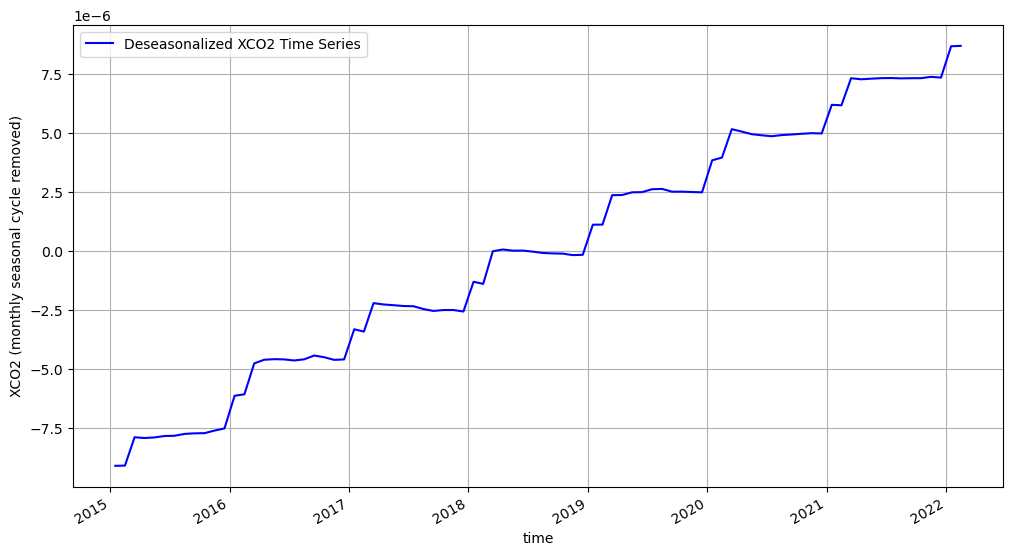

In [4]:
import matplotlib.pyplot as plt

# 读取数据
CO2_data = xr.open_dataset("oco2_GEOS_L3CO2_month_2015_2022.nc")

# 选择目标变量 XCO2
variable_name = 'XCO2'  # 指定目标变量名称
XCO2_data = CO2_data[variable_name]  # 将变量存储到 XCO2_data
# print(f"成功加载变量 '{variable_name}'！")

# 按月份分组，计算每个月的多年平均值（气候平均）
# 使用 groupby 方法对时间维度 'time.month' 分组，计算每月的平均值
monthly_means = XCO2_data.groupby('time.month').mean(dim='time')

# 去除月度季节周期
# 从原始数据中减去对应月份的多年平均值
deseasonalized_XCO2 = XCO2_data.groupby('time.month') - monthly_means

# 绘制去季节周期后的时间序列
plt.figure(figsize=(12, 6))  # 设置图形大小
# 对所有纬度和经度取平均值，并绘制时间序列
deseasonalized_XCO2.mean(dim=['lat', 'lon']).plot(label="Deseasonalized XCO2 Time Series", color='blue')
plt.xlabel("time")  # 设置x轴标签
plt.ylabel("XCO2 (monthly seasonal cycle removed)")  # 设置y轴标签
plt.legend()  # 添加图例
plt.grid()  # 添加网格线
plt.show()  # 显示图形




**3.2** [10 points] Make at least 5 different plots using the dataset.

1. 绘制可视化XCO2地图

E:\anaconda3\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


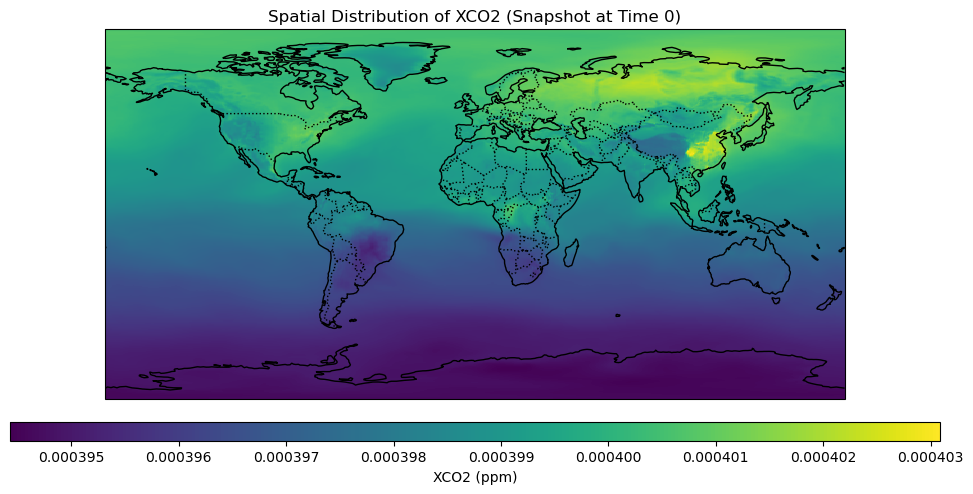

In [14]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 绘制地图
plt.figure(figsize=(12, 6))

# 使用 Cartopy 的投影设置
ax = plt.axes(projection=ccrs.PlateCarree())  # 平面投影
ax.coastlines()  # 添加海岸线
ax.add_feature(cfeature.BORDERS, linestyle=':')  # 添加国界线
ax.add_feature(cfeature.LAND, facecolor='lightgray')  # 添加陆地背景

# 绘制 XCO2 的空间分布
im = plt.pcolormesh(
    XCO2_snapshot['lon'], XCO2_snapshot['lat'], XCO2_snapshot,
    cmap='viridis', transform=ccrs.PlateCarree()
)

# 添加颜色条
cbar = plt.colorbar(im, orientation='horizontal', pad=0.05, aspect=50)
cbar.set_label(f"{variable_name} (ppm)")

# 设置标题
plt.title(f"Spatial Distribution of {variable_name} (Snapshot at Time 0)")
plt.show()


2. 热力图 (Heatmap)

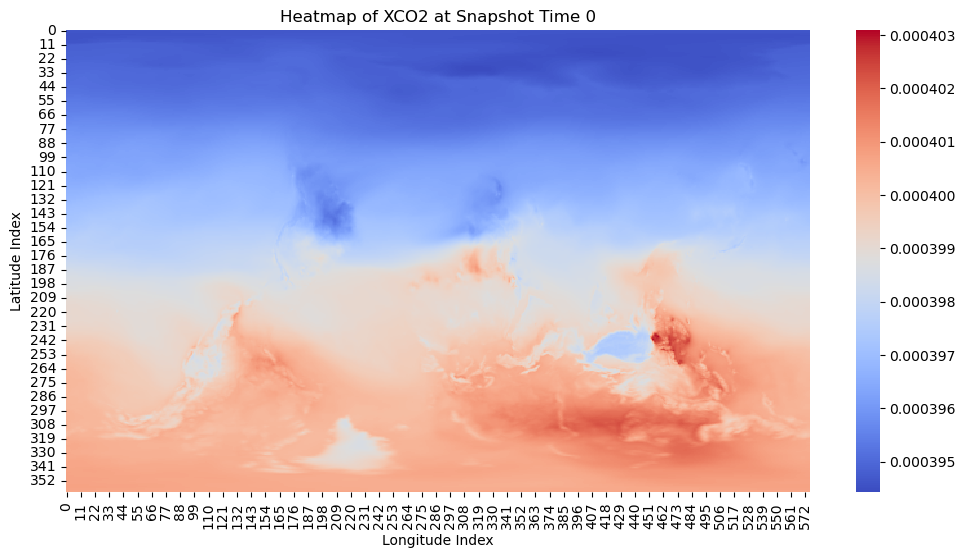

In [17]:
import seaborn as sns

# 将 XCO2 数据转换为二维数组并绘制热力图
snapshot_2d = XCO2_snapshot.values  # 提取数值
plt.figure(figsize=(12, 6))
sns.heatmap(snapshot_2d, cmap="coolwarm", cbar=True)
plt.title("Heatmap of XCO2 at Snapshot Time 0")
plt.xlabel("Longitude Index")
plt.ylabel("Latitude Index")
plt.show()


3. 三维表面图

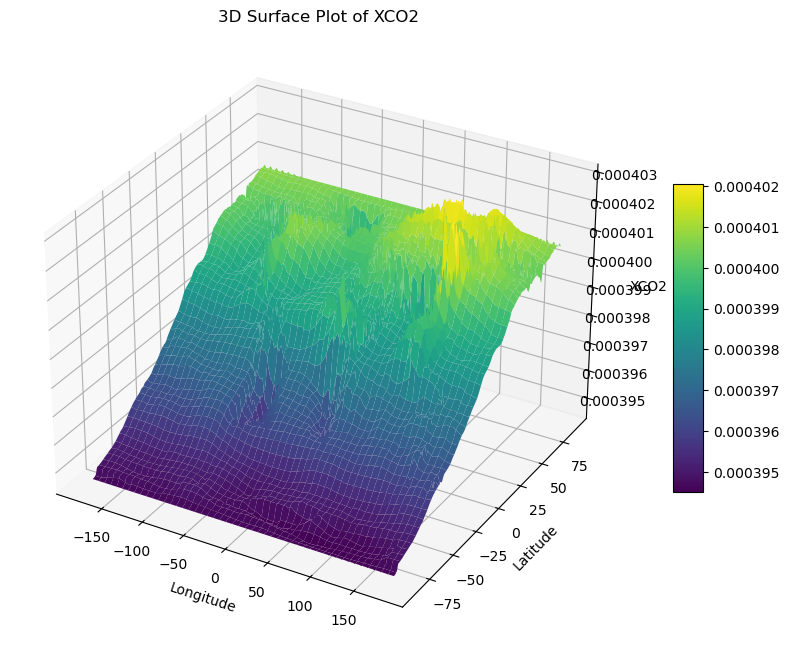

In [18]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 准备三维数据
lon_grid, lat_grid = np.meshgrid(XCO2_snapshot['lon'], XCO2_snapshot['lat'])
values = XCO2_snapshot.values

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(lon_grid, lat_grid, values, cmap='viridis')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_title("3D Surface Plot of XCO2")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("XCO2")
plt.show()


4. 直方图

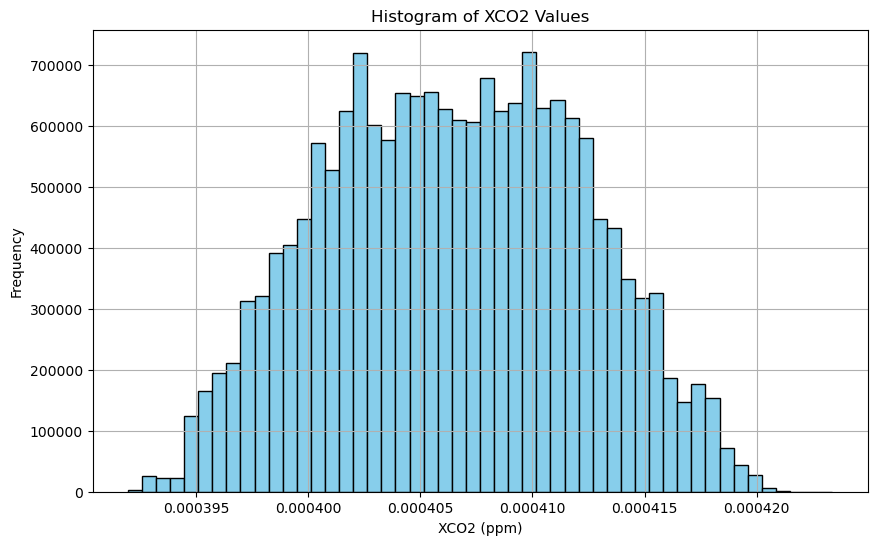

In [22]:
# 提取所有时间点和空间点的 XCO2 值
all_values = XCO2_data.values.flatten()

plt.figure(figsize=(10, 6))
plt.hist(all_values, bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of XCO2 Values")
plt.xlabel("XCO2 (ppm)")
plt.ylabel("Frequency")
plt.grid()
plt.show()


5. 小提琴图

C:\Users\a\AppData\Local\Temp\ipykernel_8312\2243963290.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['year'] = df_filtered['time'].dt.year
C:\Users\a\AppData\Local\Temp\ipykernel_8312\2243963290.py:13: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


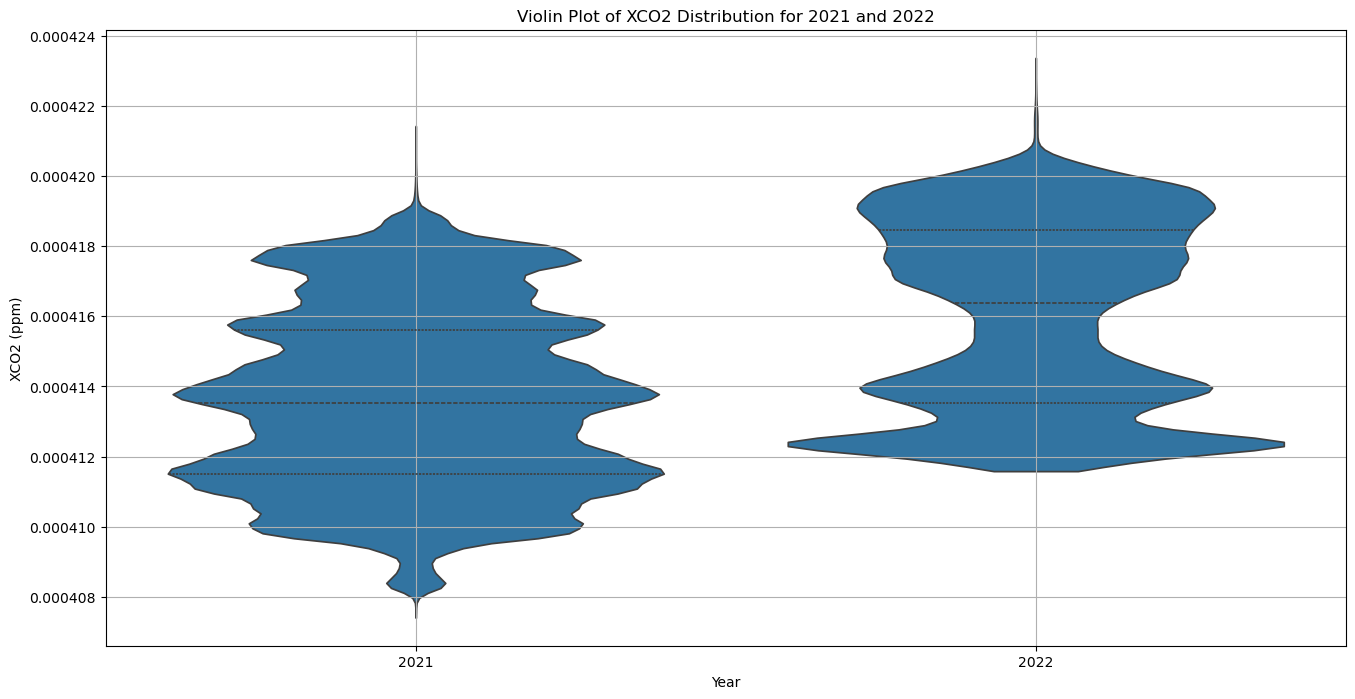

In [28]:
# 将数据转换为 Pandas DataFrame
df = XCO2_data.to_dataframe().reset_index()

# 筛选出 2021 和 2022 年的数据
df['time'] = pd.to_datetime(df['time'])  # 确保时间列为 datetime 格式
df_filtered = df[(df['time'].dt.year == 2021) | (df['time'].dt.year == 2022)]

# 添加年份列以便分组
df_filtered['year'] = df_filtered['time'].dt.year

# 绘制小提琴图
plt.figure(figsize=(16, 8))
sns.violinplot(
x="year", y="XCO2", data=df_filtered, scale="width", cut=0, inner="quartile"
)
plt.title("Violin Plot of XCO2 Distribution for 2021 and 2022")
plt.xlabel("Year")
plt.ylabel("XCO2 (ppm)")
plt.grid()
plt.show()